In [69]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.rcParams.update({"font.size": 20, "xtick.direction": "in", "ytick.direction": "in"})
#np.set_printoptions(threshold=sys.maxsize)

C = 299_800_000

In [70]:
def lim(function, target, l0, r0):
    converging = True

    while converging:
        l1, r1 = np.mean([l0, target]), np.mean([r0, target]) # Half the difference between the left/right hand value and the target
        l2, r2 = np.mean([l1, target]), np.mean([r1, target])

        fl0, fr0 = function(l0), function(r0)
        fl1, fr1 = function(l1), function(r2)
        fl2, fr2 = function(l2), function(r2)

        delta_l0, delta_r0 = np.abs(fl1 -fl0), np.abs(fr1 -fr0)
        delta_l1, delta_r1 = np.abs(fl2 -fl1), np.abs(fr2 -fr1)

        if delta_l1 < delta_l0 and delta_r1 < delta_r0: #limit is converging :)
            l0, r0 = l1, r1
        else: #limit is diverging >:(. This is assumed to be a numerical error rather than a mathematical property of the function.
            converging = False

    return np.mean([fl0, fr0]) #Given that the limit converges, it should lie somewhere between the left and right hand limits.

def kramers_kronig(omega, rho):
    assert len(omega) == len(rho), "All values in the function must have a corrisponding frequency."
    N = len(omega)

    sort = np.argsort(omega)
    unsort = np.argsort(sort)
    delta_omega = np.diff(omega[sort], append= 2*omega[sort][-1] -omega[sort][-2]) # Extrapolate the last value.
    delta_omega = delta_omega[unsort] # When approximatating an intergral to the sum of many rectangles, we must find the area by multiplying by the width of the rectangles.

    summation = np.zeros(N)
    integrand = np.zeros(N)

    for x, dx, rho_x, n in zip(omega, delta_omega, rho, np.arange(N)):
        numerator = -omega *np.log(rho_x /rho)
        denominator = omega**2 -x**2
        integrand= numerator/denominator

        ###### SOLVING LIMIT #####
        rho_func = lambda y: np.interp(y, omega, rho)
        integrand_func = lambda y: -x *np.log(rho_func(y)/rho_x) /(x**2 -y**2) # I have used x as the frequency and y as the integral variable. (instead of omega and x)

        integrand[n] = lim(integrand_func, x, x-dx, x+dx)

        summation += integrand *dx

    return 2/np.pi *summation

def recip(x):
    return C*1e-6 / x #converts um to THz or vice versa.

def format_ticks(x, pos):
    return f"{x:.1f}"  # Format the tick label with one decimal place

def gaussian(x, center, FWHM):
    sigma = (8 *np.log(2))**-0.5 *FWHM
    exponent = -(1/2) *(x -center)**2 /(sigma**2)
    return np.exp(exponent)

In [71]:
File = open("plotDataqq.txt", 'rt')
epac_data = np.loadtxt(File, delimiter = " ")
File.close()

ideal_z, ideal_bunch = epac_data.T # Z displacement in um, bunch profile normalised to its peak(?)

ideal_time = ideal_z *1e-6 /C # in s
ideal_sampling_period = np.median(np.diff(ideal_time)) # should be regularly spaced anyway
ideal_N = len(ideal_time)
#ideal_bunch /= np.sum(ideal_bunch) # normalise to its intergral

#ideal_bunch[:100] = 0

In [72]:
padding = 10000 # number of samples to zero padd at the end of the bunch

ideal_time = np.append(ideal_time, ideal_time[-1] +ideal_sampling_period*np.arange(padding))
ideal_bunch = np.append(ideal_bunch, np.zeros(padding))
padded_N = len(ideal_bunch) # = ideal_N +padding

#ideal_time = np.append(ideal_sampling_period*np.arange(padded_N-2) -ideal_time[-1], ideal_time)
#ideal_bunch = np.append(np.zeros(padded_N -2), ideal_bunch)
#padded_N = len(ideal_bunch)

In [73]:
### Replace the EPAC bunch with a gaussian distrobution. Useful for testing.

FWHMs = {"short": 1.7e-15, "delayed": 5e-15, "long": 21e-15}
bunch_dict = {}

ideal_bunch = gaussian(ideal_time, 150e-15, FWHMs["delayed"])

In [74]:
ideal_CFF = np.fft.rfft(ideal_bunch, norm= "forward")
ideal_CFF /= np.max(ideal_CFF) #normalise to peak
ideal_freqs = np.fft.rfftfreq(padded_N, ideal_sampling_period)

ideal_FF = np.abs(ideal_CFF)**2
ideal_FF /= np.max(ideal_FF) #normalise to peak

In [75]:
sin_minutes = lambda min: np.sin(np.deg2rad(min/60))

def measure_form_factor(freqencies, form_factor, number_of_pixels, pixel_pitch, theta, senstivity_band= (0, np.inf)):
    time_resolution = (2*sin_minutes(theta)*pixel_pitch*1e-6) / C
    times = np.arange(0, time_resolution*number_of_pixels, time_resolution)
    detectable_frequencies = np.fft.rfftfreq(number_of_pixels, time_resolution)
    measured_form_factor = np.interp(detectable_frequencies, freqencies, form_factor)
    sensitivity_mask = np.logical_and(senstivity_band[0]*1e12 < detectable_frequencies, detectable_frequencies < senstivity_band[1]*1e12)
    measured_form_factor[~sensitivity_mask] = 0.0 #camera is insensitive to these frequencies and so it will read zero.
    return detectable_frequencies, measured_form_factor, sensitivity_mask, times


In [76]:
thetas = [30, 30] #arcminutes
Ns = [640, 320] # number of pixels
dxs = [20, 48.5] # pixel pitch in um
bands = [(176.3, 299.8), (15, 176.3)] # sensitivity of camera. (minmimum frequency in THz, maximum frequency in THz)
#bands = [(0, 299.8), (0, np.inf)]
colours = ["forestgreen", "crimson"] #colour of this detectors datapoints when plotting
labels = ["Xeva", "PV320"] #label of this detector when plotting

bands = np.array(bands)
freqs, FFs, sensitivity_masks, times = [], [], [], []
for theta, N, dx, band in zip(thetas, Ns, dxs, bands):
    freq, FF, sensitivity_mask, time = measure_form_factor(ideal_freqs, ideal_FF, N, dx, theta, band)
    freqs, FFs, sensitivity_masks, times = freqs+[freq], FFs+[FF], sensitivity_masks+[sensitivity_mask], times+[time]
    

In [77]:
print(1e-12*np.mean(np.diff(freqs[0])))
print(1e-12*np.mean(np.diff(freqs[1])))


1.3419916188024639
1.106797211383475


C:\Users\syf83691\AppData\Local\Temp\ipykernel_17844\1078799044.py:50: RuntimeWarning: divide by zero encountered in divide
  return C*1e-6 / x #converts um to THz or vice versa.


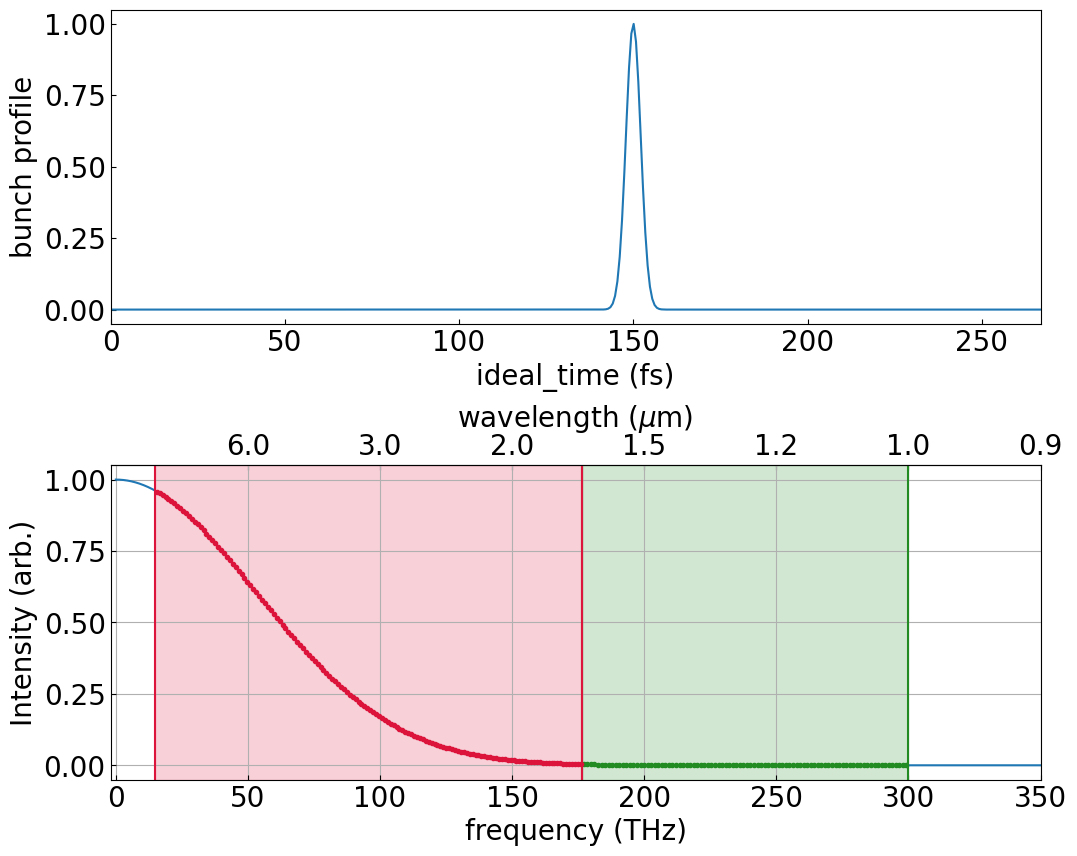

In [78]:
fig, axs = plt.subplots(2, 1, figsize= (12, 10), gridspec_kw= {"hspace": 0.45})

axs[0].plot(ideal_time *1e15, ideal_bunch)
axs[0].set(xlabel= "ideal_time (fs)", ylabel= "bunch profile", xlim= (0, ideal_N*ideal_sampling_period*1e15))

axs[1].plot(ideal_freqs *1e-12, ideal_FF)
axs[1].set(xlabel= "frequency (THz)", ylabel= "Intensity (arb.)", xlim= (-2, 350))
axs[1].grid(True)

for freq, FF, band, sensitivity_mask, colour, label in zip(freqs, FFs, bands, sensitivity_masks, colours, labels):
    axs[1].plot(freq[sensitivity_mask] *1e-12, FF[sensitivity_mask], linestyle= "None", marker= ".", color= colour)
    axs[1].fill_betweenx([0,1], 2*[band[0]], 2*[band[1]], color= colour, alpha= 0.2, transform= axs[1].get_xaxis_transform(), label= "{0:} bandwidth".format(label))
    axs[1].vlines(band, 0, 1, color= colour, transform= axs[1].get_xaxis_transform())

secax = axs[1].secondary_xaxis('top', functions=(recip, recip))
secax.set(xlabel= "wavelength ($\mu$m)", xticks= recip(axs[1].get_xticks()[2:]))
secax.xaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_17844\1078799044.py:50: RuntimeWarning: divide by zero encountered in divide
  return C*1e-6 / x #converts um to THz or vice versa.


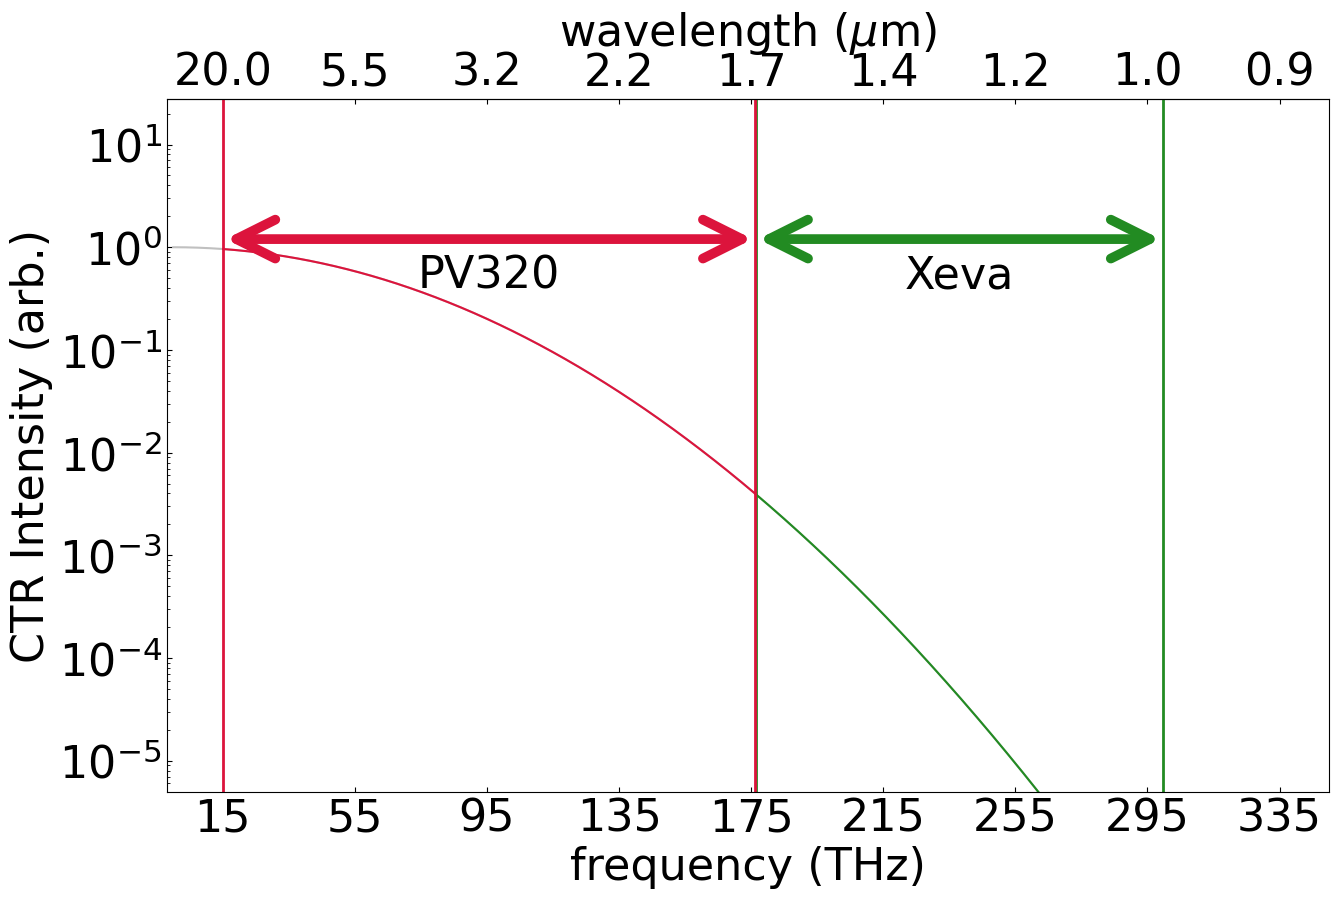

In [79]:
plt.rcParams.update({"font.size": 32, "xtick.direction": "in", "ytick.direction": "in", "xtick.major.top": True, "ytick.major.right": True})


fig, axs = plt.subplots(1, 1, figsize= (15, 9), facecolor='none')

axs.plot(ideal_freqs *1e-12, ideal_FF, color= "silver")
axs.set(xlabel= "frequency (THz)", ylabel= "CTR Intensity (arb.)", xlim= (-2, 350), yscale= "log", ylim= (5e-6, None), xticks= np.arange(15,351,40))

for freq, FF, band, sensitivity_mask, colour, label in zip(freqs, FFs, bands, sensitivity_masks, colours, labels):

    is_in_range = np.logical_and(band[0]*1e12 < ideal_freqs, ideal_freqs < band[1]*1e12)
    axs.plot(ideal_freqs[is_in_range] *1e-12, ideal_FF[is_in_range], color= colour)

    #axs.plot(freq[sensitivity_mask] *1e-12, FF[sensitivity_mask], linestyle= "None", marker= ".", color= colour)
    axs.annotate("", xy= (band[1],1.2), xytext= (band[0],1.2), arrowprops=dict(arrowstyle='<->', color= colour, linewidth= 7, mutation_scale= 70))
    axs.annotate(label, xy= (np.mean(band), 0.4), horizontalalignment='center')
    axs.vlines(band +np.array((0.2,-0.2)), 0, 1, color= colour, transform= axs.get_xaxis_transform(), linewidth= 2)

axs.set_facecolor("white")

secax = axs.secondary_xaxis('top', functions=(recip, recip))
secax.set(xlabel= "wavelength ($\mu$m)", xticks= recip(axs.get_xticks()))
secax.xaxis.set_major_formatter(FuncFormatter(format_ticks))

#plt.savefig("graphs\\ff_sampling")
plt.show()

In [80]:
from scipy import signal as scisig

def find_best_peak(interferograms, height=None, threshold=None, distance=None, width=None, wlen=None, rel_height=0.5, plateau_size=None):
    if interferograms.ndim == 1:
        peaks, peaks_properties = scisig.find_peaks(interferograms, height=height, threshold=threshold, distance=distance, prominence=0, width=width, wlen=wlen, rel_height=rel_height, plateau_size=plateau_size)
        best_peak_index = np.argmax(peaks_properties["prominences"])
        peak = peaks[best_peak_index]
        peak_properties = {key: value[best_peak_index] for key, value in peaks_properties.items()}
    
    elif interferograms.ndim == 2:
        interferograms = interferograms.transpose() #Use the right set of axes.
        peaks, peaks_properties = scisig.find_peaks(interferograms[0], height=height, threshold=threshold, distance=distance, prominence=0, width=width, wlen=wlen, rel_height=rel_height, plateau_size=plateau_size)
        best_peak_index = np.argmax(peaks_properties["prominences"])
        peak = [peaks[best_peak_index]]
        peak_properties = {key: [value[best_peak_index]] for key, value in peaks_properties.items()}

        for interferogram in interferograms[1:]:
            peaks, peaks_properties = scisig.find_peaks(interferogram, height=height, threshold=threshold, distance=distance, prominence=0, width=width, wlen=wlen, rel_height=rel_height, plateau_size=plateau_size)
            best_peak_index = np.argmax(peaks_properties["prominences"])
            peak = np.concatenate([peak, [peaks[best_peak_index]]])
            peak_properties = {key: peak_properties[key] +[value[best_peak_index]] for key, value in peaks_properties.items()}

    else:
        raise IndexError("find_best_peak expected interferograms to have 1 or 2 dimentions. Got {0:}".format(interferograms.ndim))
    return peak, peak_properties

In [81]:
peak, peak_params = find_best_peak(ideal_bunch, width= 0)
print(peak_params)

FWHM = ideal_sampling_period*peak_params["widths"]
print(FWHM*1e15)

{'prominences': 0.9988901007114375, 'left_bases': 102, 'right_bases': 348, 'widths': 7.514340510520896, 'width_heights': 0.49944505035571873, 'left_ips': 221.09703592157146, 'right_ips': 228.61137643209236}
5.012902275215594


In [82]:
########## INTERPOLATION AND COMBINING DATA ##################

dfs, nyquists = [], []
for theta, N, dx in zip(thetas, Ns, dxs):
    df = C / (2*sin_minutes(theta)*N*dx*1e-6)
    nyquist = C / (4*sin_minutes(theta)*dx*1e-6)
    dfs, nyquists = dfs+[df], nyquists+[nyquist]

combined_df = np.min(dfs)
combined_nyquist = np.max(nyquists)
print("To combine the spectra, we will assume that we have a {0:.2f} THz resolution up to the nyquist frequency of {1:.1f} THz.".format(combined_df*1e-12, combined_nyquist*1e-12))

combined_dt = 0.5/combined_nyquist
combined_length = 1/combined_df
Ns += [round(combined_length/combined_dt +1)]
times += [np.arange(0, combined_length +combined_dt/2, combined_dt)]

freqs += [np.arange(0, combined_nyquist +combined_df/2, combined_df)]
temp_f = np.concatenate([freq[sensitivity_mask] for freq, sensitivity_mask in zip(freqs, sensitivity_masks)])
temp_FF = np.concatenate([FF[sensitivity_mask] for FF, sensitivity_mask in zip(FFs, sensitivity_masks)])
_, sort = np.unique(temp_f, return_index= True)
FFs += [np.interp(freqs[-1], temp_f[sort], temp_FF[sort])] # NP.INTERP WILL ALSO EXTRAPOLATE. It does linear interpolation and nearest neighbor extrapolation.
sensitivity_masks += [np.any([np.logical_and(band[0]*1e12 < freqs[-1], freqs[-1] < band[1]*1e12) for band in bands], axis= 0)]

labels += ["combined"]
colours += ["black"]

To combine the spectra, we will assume that we have a 1.11 THz resolution up to the nyquist frequency of 429.4 THz.


In [83]:
len(freqs[2])

389

In [84]:
def phase_retrieval(freq, FF, sensitivity_mask, time, N, reflected= False, shifted= False):
    phase = np.zeros_like(freq)
    phase[sensitivity_mask] = kramers_kronig(freq[sensitivity_mask], np.sqrt(FF[sensitivity_mask]))

    ############## FUDGE FACTORS FOR AMBIGUITY PROBLEM ############## 
    """ There are 3 sources of ambiguity.
    TIME SHIFT : Doesn't matter much. Can be resolved if you know (for example) when the peak occours.
    REFLECTION : Slightly more problematic. Could be resolved if you know the order of the bunches.
    INTERNAL STRUCTURE : Big problem at high resolution with no obvious fix. Numberical methods like the Gerchberg-Saxton algorithm try to find the most probable internal structure.
    """
    fudged = phase

    ### REFLECTION
    if reflected: fudged = -phase

    ### TIME SHIFT
    if shifted:
        CFF = np.sqrt(FF) *np.exp(1j*fudged) #apply phase
        bunch = np.fft.irfft(CFF, norm= "forward", n= N)
        ideal_peak = ideal_time[np.argmax(ideal_bunch)]
        peak = time[np.argmax(bunch)]

        fudged -= 2*np.pi*freq* (ideal_peak -peak) # Equivalently, change the phase


    CFF = np.sqrt(FF) *np.exp(1j*fudged) #apply phase
    bunch = np.fft.irfft(CFF, norm= "forward", n= N) #inverse fourier transform
    bunch /= np.max(bunch) #normalise

    return phase, fudged, CFF, bunch

phases, fudges, CFFs, bunches = [], [], [], []
for freq, FF, sensitivity_mask, time, N in zip(freqs, FFs, sensitivity_masks, times, Ns):
    phase, fudged, CFF, bunch = phase_retrieval(freq, FF, sensitivity_mask, time, N, reflected= True, shifted= True)
    phases, fudges, CFFs, bunches = phases+[phase], fudges+[fudged], CFFs+[CFF], bunches+[bunch]

C:\Users\syf83691\AppData\Local\Temp\ipykernel_17844\1078799044.py:37: RuntimeWarning: invalid value encountered in divide
  integrand= numerator/denominator


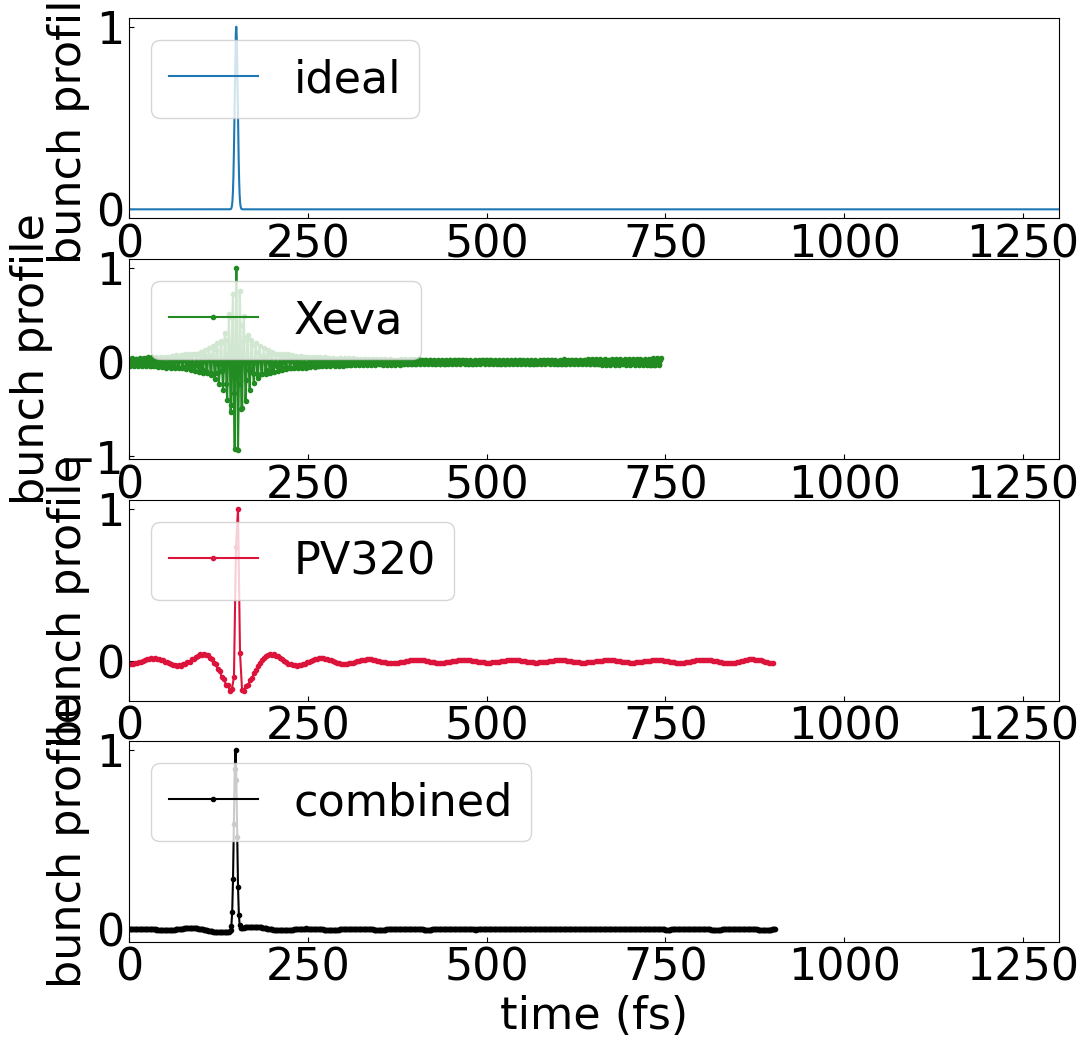

In [85]:
fig, axs = plt.subplots(len(labels) +1, 1, figsize= (12, 12), gridspec_kw= {"hspace": 0.2})

axs[0].plot(ideal_time *1e15, ideal_bunch, label= "ideal")

for ax, time, bunch, colour, label in zip(axs[1:], times, bunches, colours, labels):
    ax.plot(time *1e15, bunch, marker= ".", label= label, color= colour)

for ax in axs:
    ax.set(xlabel= "time (fs)", ylabel= "bunch profile", xlim= (0, 1300))
    ax.legend(loc= "upper left")

plt.show()

In [86]:
np.max(times[-1] *1e15)

903.5078781505232

C:\Users\syf83691\AppData\Local\Temp\ipykernel_17844\1078799044.py:37: RuntimeWarning: invalid value encountered in divide
  integrand= numerator/denominator
C:\Users\syf83691\AppData\Local\Temp\ipykernel_17844\1078799044.py:50: RuntimeWarning: divide by zero encountered in divide
  return C*1e-6 / x #converts um to THz or vice versa.


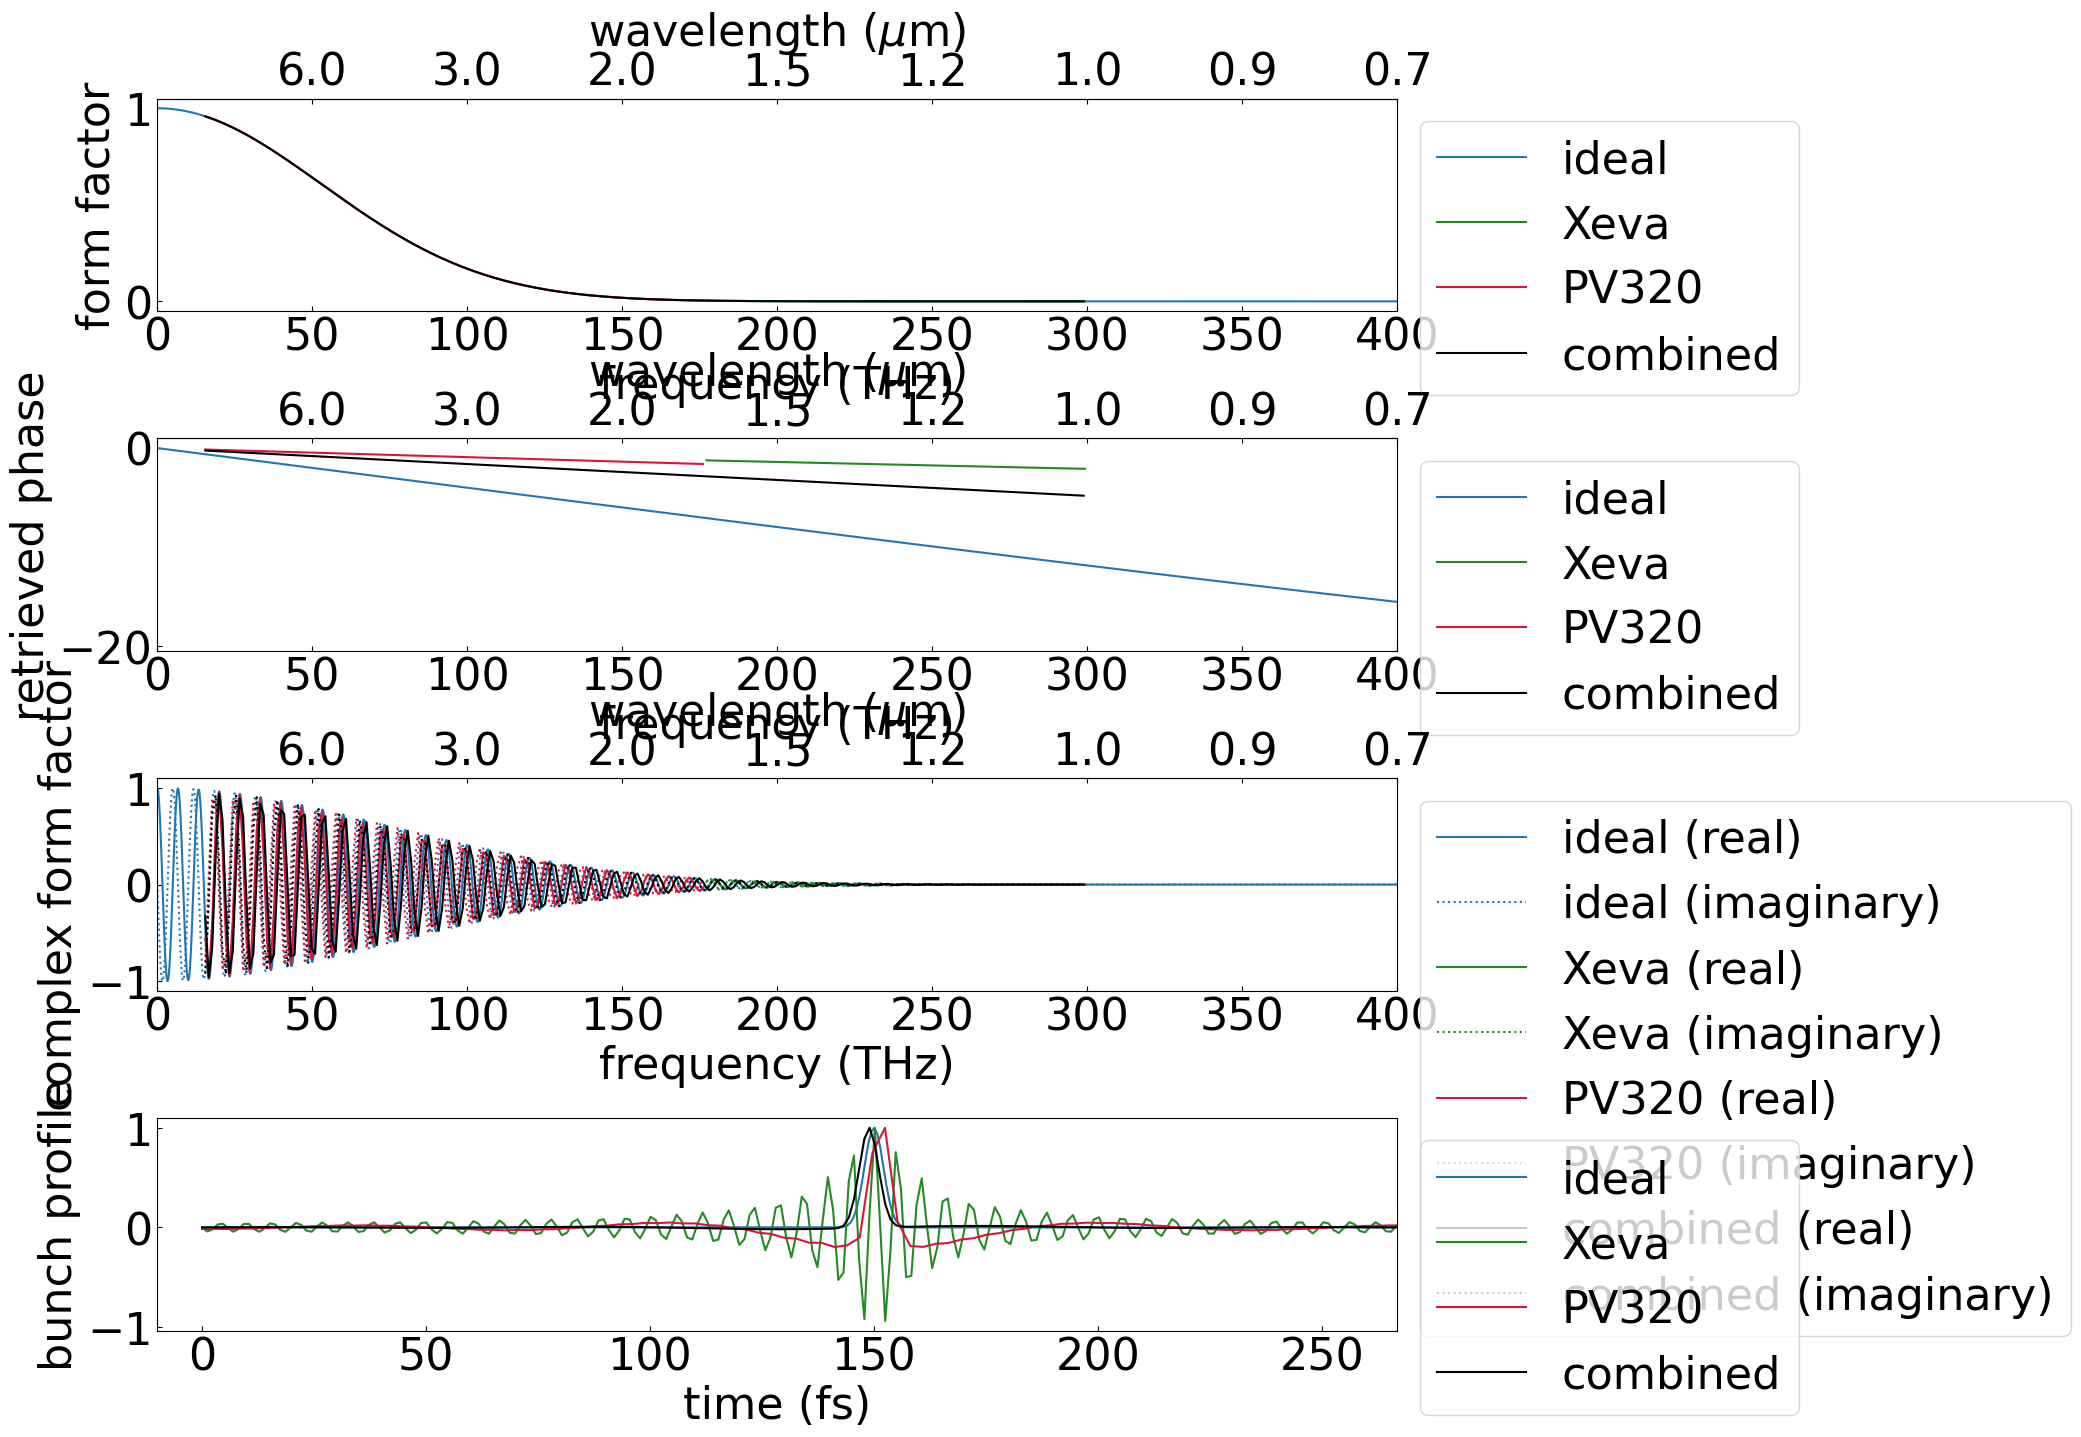

In [87]:
fig, axs = plt.subplots(4, 1, figsize= (16, 16), gridspec_kw= {"hspace": 0.6})

axs[0].plot(ideal_freqs *1e-12, ideal_FF, color= "tab:blue", label= "ideal", zorder= 1.7)
axs[1].plot(ideal_freqs *1e-12, kramers_kronig(ideal_freqs, np.sqrt(ideal_FF)), color= "tab:blue", label= "ideal", zorder= 1.7)
axs[2].plot(ideal_freqs *1e-12, ideal_CFF.real, color= "tab:blue", label= "ideal (real)", zorder= 1.7)
axs[2].plot(ideal_freqs *1e-12, ideal_CFF.imag, color= "tab:blue", linestyle= ":", label= "ideal (imaginary)", zorder= 1.7)
axs[3].plot(ideal_time *1e15, ideal_bunch, color= "tab:blue", label= "ideal", zorder= 1.7)

for freq, FF, CFF, phase, mask, time, bunch, colour, label in zip(freqs, FFs, CFFs, phases, sensitivity_masks, times, bunches, colours, labels):
    axs[0].plot(freq[mask] *1e-12, FF[mask], color= colour, label= label)
    axs[1].plot(freq[mask] *1e-12, phase[mask], color= colour, label= label)
    axs[2].plot(freq[mask] *1e-12, CFF[mask].real, color= colour, label= "{0:} (real)".format(label))
    axs[2].plot(freq[mask] *1e-12, CFF[mask].imag, linestyle= ":", color= colour, label= "{0:} (imaginary)".format(label))
    axs[3].plot(time *1e15, bunch, color= colour, label= label)

axs[0].set(xlabel= "frequency (THz)", ylabel= "form factor", xlim= (1e-10, 400))
axs[1].set(xlabel= "frequency (THz)", ylabel= "retrieved phase", xlim= (1e-10, 400))
axs[2].set(xlabel= "frequency (THz)", ylabel= "complex form factor", xlim= (1e-10, 400))
axs[3].set(xlabel= "time (fs)", ylabel= "bunch profile", xlim= (-10, ideal_N*ideal_sampling_period*1e15))

secax0 = axs[0].secondary_xaxis('top', functions=(recip, recip))
secax0.set(xlabel= "wavelength ($\mu$m)", xticks= recip(axs[0].get_xticks()[1:]))
secax0.xaxis.set_major_formatter(FuncFormatter(format_ticks))
secax1 = axs[1].secondary_xaxis('top', functions=(recip, recip))
secax1.set(xlabel= "wavelength ($\mu$m)", xticks= recip(axs[1].get_xticks()[1:]))
secax1.xaxis.set_major_formatter(FuncFormatter(format_ticks))
secax2 = axs[2].secondary_xaxis('top', functions=(recip, recip))
secax2.set(xlabel= "wavelength ($\mu$m)", xticks= recip(axs[2].get_xticks()[1:]))
secax2.xaxis.set_major_formatter(FuncFormatter(format_ticks))

for ax in axs:
    ax.legend(loc= "upper left", bbox_to_anchor= (1, 1))

plt.show()

In [88]:
times[-1]

array([0.00000000e+00, 1.16431428e-15, 2.32862855e-15, 3.49294283e-15,
       4.65725710e-15, 5.82157138e-15, 6.98588566e-15, 8.15019993e-15,
       9.31451421e-15, 1.04788285e-14, 1.16431428e-14, 1.28074570e-14,
       1.39717713e-14, 1.51360856e-14, 1.63003999e-14, 1.74647141e-14,
       1.86290284e-14, 1.97933427e-14, 2.09576570e-14, 2.21219712e-14,
       2.32862855e-14, 2.44505998e-14, 2.56149141e-14, 2.67792283e-14,
       2.79435426e-14, 2.91078569e-14, 3.02721712e-14, 3.14364855e-14,
       3.26007997e-14, 3.37651140e-14, 3.49294283e-14, 3.60937426e-14,
       3.72580568e-14, 3.84223711e-14, 3.95866854e-14, 4.07509997e-14,
       4.19153139e-14, 4.30796282e-14, 4.42439425e-14, 4.54082568e-14,
       4.65725710e-14, 4.77368853e-14, 4.89011996e-14, 5.00655139e-14,
       5.12298281e-14, 5.23941424e-14, 5.35584567e-14, 5.47227710e-14,
       5.58870852e-14, 5.70513995e-14, 5.82157138e-14, 5.93800281e-14,
       6.05443424e-14, 6.17086566e-14, 6.28729709e-14, 6.40372852e-14,
      

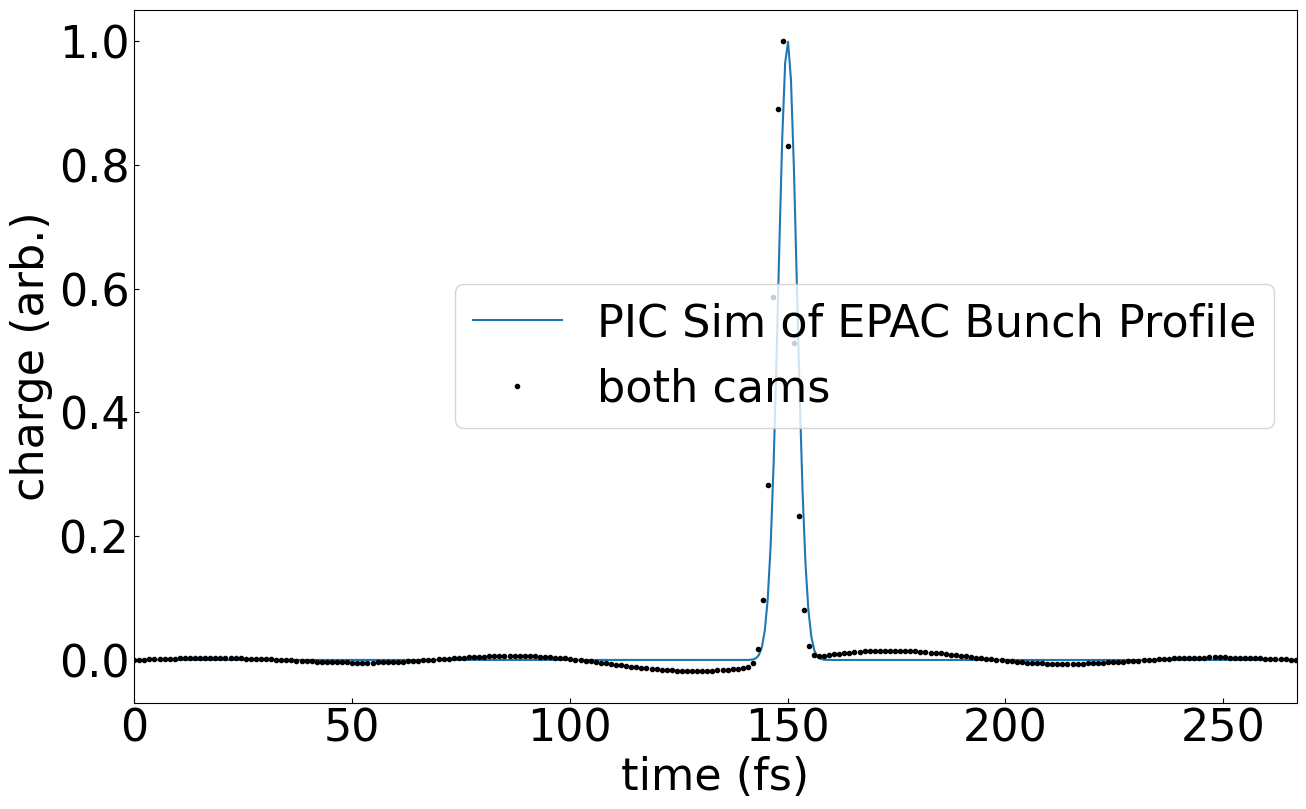

In [89]:
plt.rcParams.update({"font.size": 32, "xtick.direction": "in", "ytick.direction": "in", "xtick.major.top": True, "ytick.major.right": True})

fig, axs = plt.subplots(1, 1, figsize= (15, 9), facecolor='none')


axs.plot(ideal_time *1e15, ideal_bunch, color= "tab:blue", label= "PIC Sim of EPAC Bunch Profile", zorder= 1.7)
axs.plot(times[-1] *1e15, bunches[-1], color= "k", linestyle= "none", marker= ".", label= "both cams")
axs.set(xlabel= "time (fs)", ylabel= "charge (arb.)", xlim= (0, ideal_N*ideal_sampling_period*1e15), xticks= np.arange(0,ideal_N*ideal_sampling_period*1e15,50))
axs.legend()

axs.set_facecolor("white")

#plt.savefig("graphs\\bunch")
plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_17844\1078799044.py:37: RuntimeWarning: invalid value encountered in divide
  integrand= numerator/denominator
C:\Users\syf83691\AppData\Local\Temp\ipykernel_17844\1078799044.py:50: RuntimeWarning: divide by zero encountered in divide
  return C*1e-6 / x #converts um to THz or vice versa.


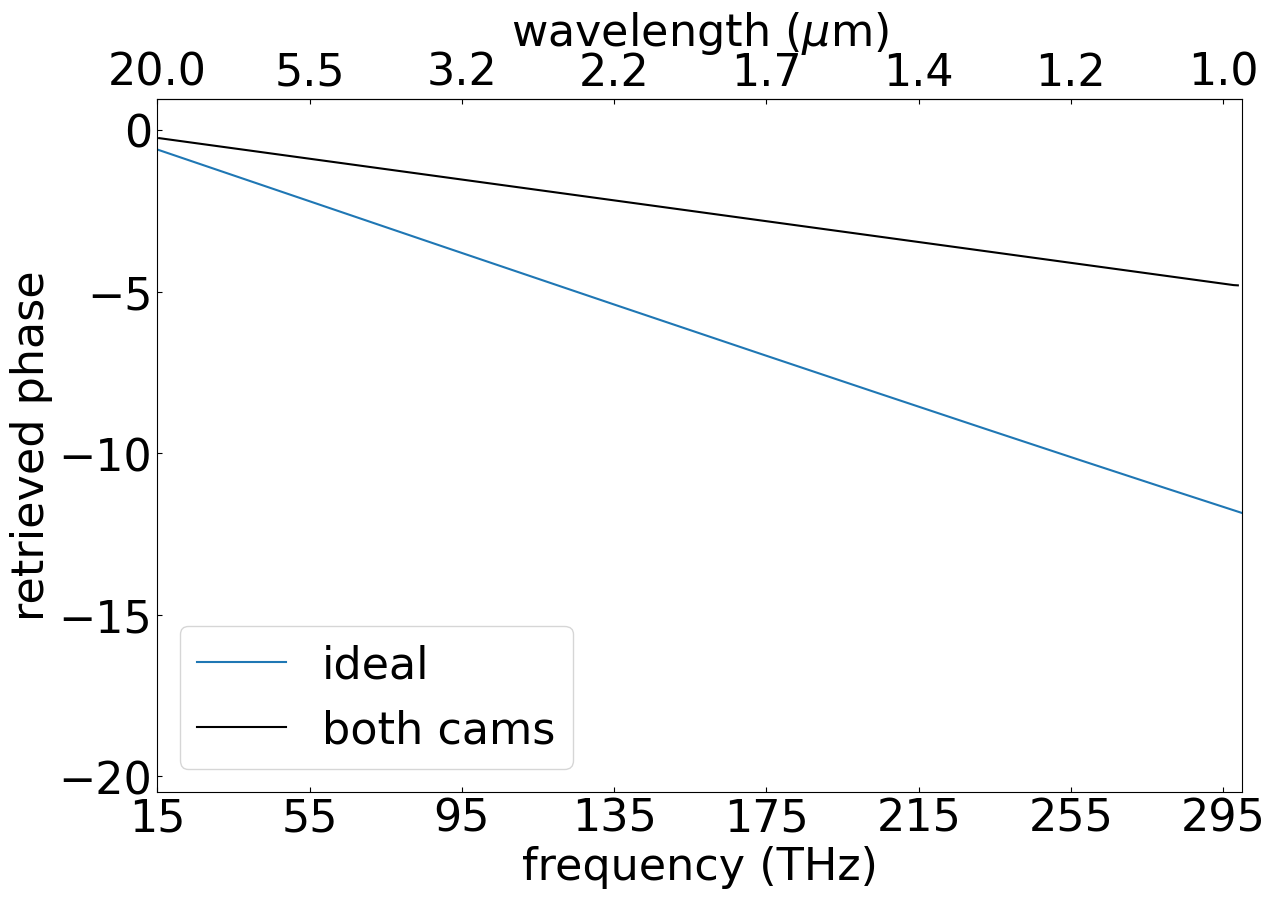

In [90]:
plt.rcParams.update({"font.size": 32, "xtick.direction": "in", "ytick.direction": "in", "xtick.major.top": True, "ytick.major.right": True})

fig, axs = plt.subplots(1, 1, figsize= (14, 9), facecolor='none')

axs.plot(ideal_freqs *1e-12, kramers_kronig(ideal_freqs, np.sqrt(ideal_FF)), color= "tab:blue", label= "ideal", zorder= 1.7)
axs.plot(freqs[-1][sensitivity_masks[-1]] *1e-12, phases[-1][sensitivity_masks[-1]], color= "k", linestyle= "-", label= "both cams")
axs.set(xlabel= "frequency (THz)", ylabel= "retrieved phase", xlim= (15, 300), xticks= np.arange(15,301,40))
axs.legend()

axs.set_facecolor("white")

secax = axs.secondary_xaxis('top', functions=(recip, recip))
secax.set(xlabel= "wavelength ($\mu$m)", xticks= recip(axs.get_xticks()))
secax.xaxis.set_major_formatter(FuncFormatter(format_ticks))

#plt.savefig("graphs\\kk_phase")
plt.show()

In [91]:
############## DEMONSTATION OF DETECTOR LIMITS #################

bunch_dict["short"] = gaussian(ideal_time, 150e-15, FWHMs["short"])
bunch_dict["long"] = gaussian(ideal_time, 150e-15, FWHMs["long"])
bunch_dict["delayed"] = gaussian(ideal_time, 150e-15, FWHMs["delayed"]) + gaussian(ideal_time, 601e-15, FWHMs["delayed"])

FFs = {}
for key, bunch in bunch_dict.items():
    CFF = np.fft.rfft(bunch, norm= "forward")
    FFs[key] = np.abs(CFF)**2
    FFs[key] /= np.max(FFs[key]) #normalise to peak

both_band = (np.min(bands[:,0]), np.max(bands[:,1]))

sensitivity_mask_short = ideal_freqs <= both_band[1]*1e12
N = 2*np.count_nonzero(sensitivity_mask_short)
time_resolution = 0.5e-12 / both_band[1]
times_short = np.arange(0, time_resolution*N, time_resolution)

_, _, _, bunch_dict["short2"] = phase_retrieval(ideal_freqs, FFs["short"], sensitivity_mask_short, times_short, 2*np.count_nonzero(sensitivity_mask_short), reflected= True, shifted= True)

freqs_delayed = np.arange(0, combined_df*N, combined_df)
FFs["delayed2"] = np.interp(freqs_delayed, ideal_freqs, FFs["delayed"])

C:\Users\syf83691\AppData\Local\Temp\ipykernel_17844\1078799044.py:37: RuntimeWarning: invalid value encountered in divide
  integrand= numerator/denominator


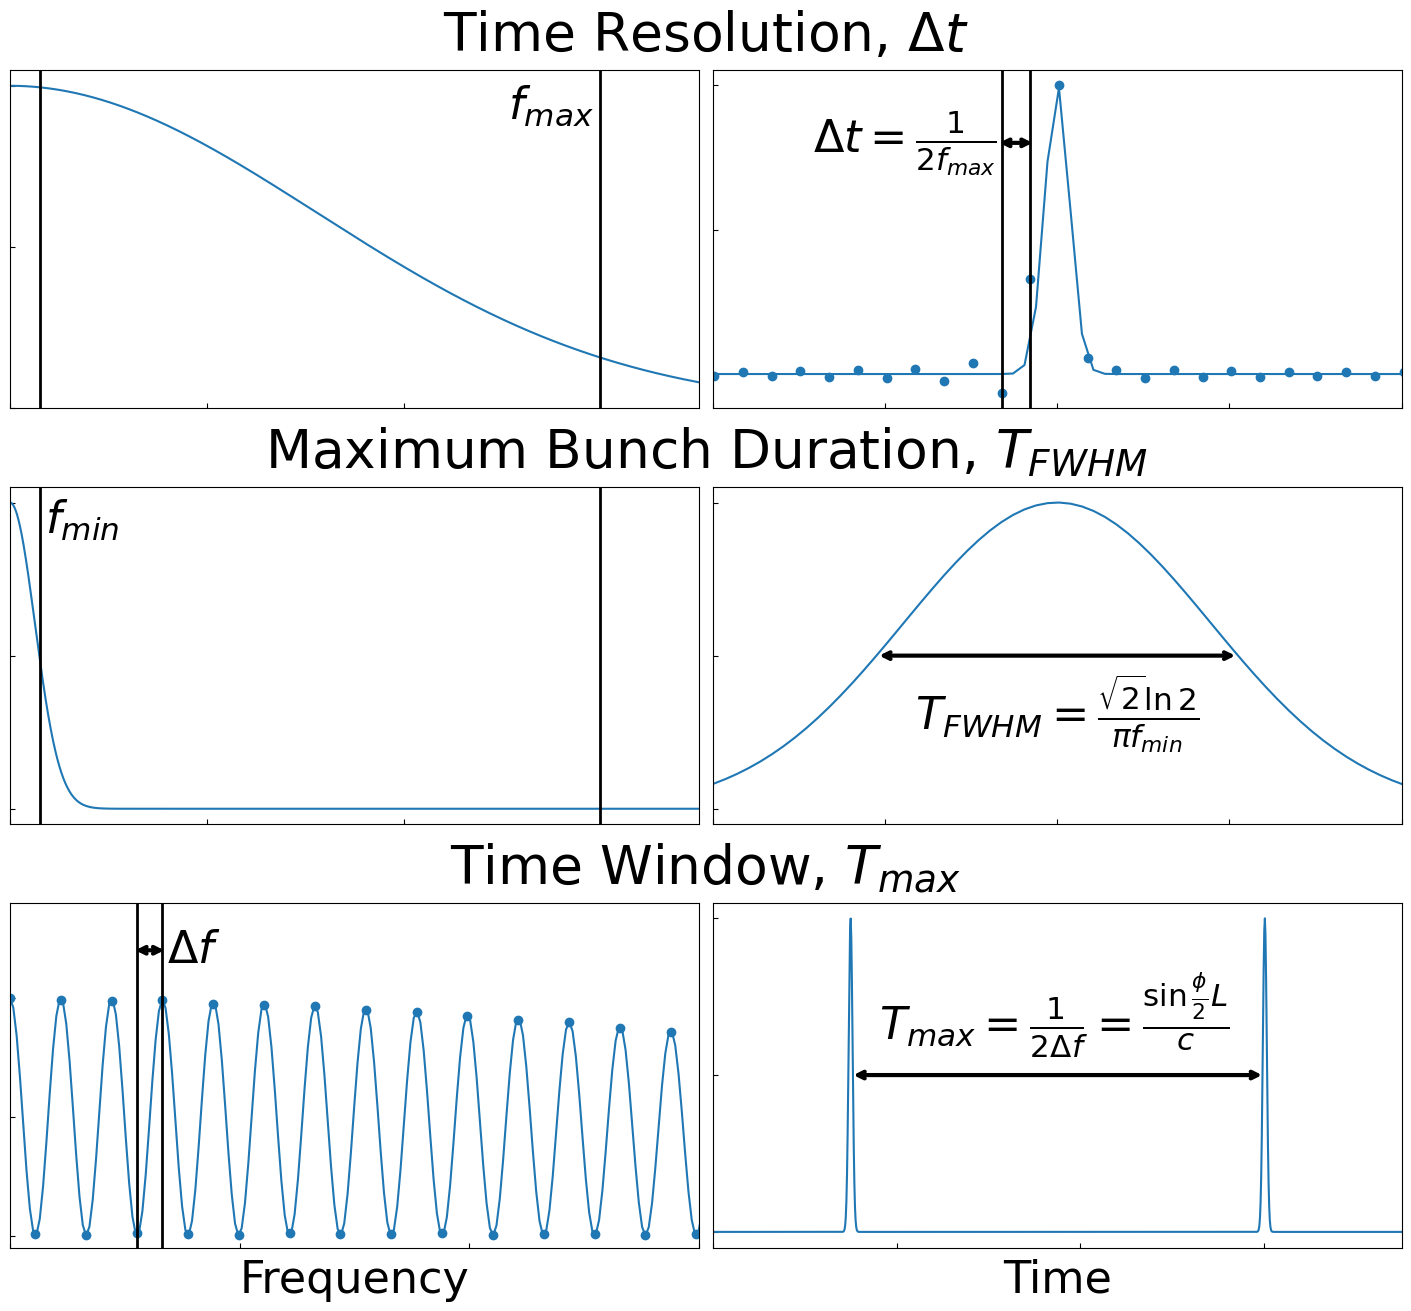

In [98]:
fig = plt.figure(layout='constrained', figsize= (14, 13), facecolor='none')
subfigs = fig.subfigures(3, 1, height_ratios= (1,1,1.15))

axs_short = subfigs[0].subplots(1, 2)
subfigs[0].suptitle("Time Resolution, $\\Delta t$")

axs_short[0].plot(ideal_freqs*1e-12, FFs["short"])
axs_short[0].vlines(both_band +np.array((0.2,-0.2)), 0, 1, color= "k", transform= axs_short[0].get_xaxis_transform(), linewidth= 2)
axs_short[0].annotate("$f_{max}$", xy= (both_band[1] -3, 0.9), horizontalalignment='right')
axs_short[0].set(xlim= (0, 350), ylim= (0, None), xticklabels= [], yticklabels= [], facecolor='white')

axs_short[1].plot(times_short*1e15, bunch_dict["short2"], marker= "o", linestyle= "none", color= "tab:blue")
axs_short[1].plot(ideal_time*1e15, bunch_dict["short"], color= "tab:blue")
axs_short[1].vlines(times_short[88:90]*1e15, 0, 1, color= "k", transform= axs_short[1].get_xaxis_transform(), linewidth= 2)
axs_short[1].annotate("", xy= (times_short[88]*1e15 -0.3,0.8), xytext= (times_short[89]*1e15 +0.3,0.8), arrowprops=dict(arrowstyle='<->', color= "k", linewidth= 3, mutation_scale= 12))
axs_short[1].annotate("$\\Delta t = \\frac{1}{2f_{max}}$", xy= (times_short[88]*1e15 -0.3, 0.8), horizontalalignment='right', verticalalignment='center')
axs_short[1].set(xlim= (130, 170), xticklabels= [], yticklabels= [], facecolor='white')


axs_long = subfigs[1].subplots(1, 2)
subfigs[1].suptitle("Maximum Bunch Duration, $T_{FWHM}$")

axs_long[0].plot(ideal_freqs*1e-12, FFs["long"])
axs_long[0].vlines(both_band +np.array((0.2,-0.2)), 0, 1, color= "k", transform= axs_long[0].get_xaxis_transform(), linewidth= 2)
axs_long[0].annotate("$f_{min}$", xy= (both_band[0] +3, 0.9), horizontalalignment='left')
axs_long[0].set(xlim= (0, 350), xticklabels= [], yticklabels= [], facecolor='white')

axs_long[1].plot(ideal_time*1e15, bunch_dict["long"])
axs_long[1].annotate("", xy= (150 -FWHMs["long"]*0.5e15,0.5), xytext= (150 +FWHMs["long"]*0.5e15,0.5), arrowprops=dict(arrowstyle='<->', color= "k", linewidth= 3, mutation_scale= 12))
axs_long[1].annotate("$T_{FWHM} = \\frac{\\sqrt{2}\\ln{2}}{\\pi f_{min}}$", xy= (150, 0.45), horizontalalignment='center', verticalalignment='top')
axs_long[1].set(xlim= (130, 170), xticklabels= [], yticklabels= [], facecolor='white')


axs_delayed = subfigs[2].subplots(1, 2)
subfigs[2].suptitle("Time Window, $T_{max}$")

axs_delayed[0].plot(freqs_delayed*1e-12, FFs["delayed2"], linestyle= "none", marker= "o", color= "tab:blue")
axs_delayed[0].plot(ideal_freqs*1e-12, FFs["delayed"], color= "tab:blue")
axs_delayed[0].vlines(freqs_delayed[5:7]*1e-12, 0, 1, color= "k", transform= axs_delayed[0].get_xaxis_transform(), linewidth= 2)
axs_delayed[0].annotate("", xy= (freqs_delayed[5]*1e-12 -0.2,1.2), xytext= (freqs_delayed[6]*1e-12 +0.2,1.2), arrowprops=dict(arrowstyle='<->', color= "k", linewidth= 3, mutation_scale= 12))
axs_delayed[0].annotate("$\\Delta f$", xy= (freqs_delayed[6]*1e-12 +0.2, 1.2), horizontalalignment='left', verticalalignment= "center")
axs_delayed[0].set(xlim= (0, 30), xticklabels= [], yticklabels= [], ylim= (None, 1.4), xlabel= "Frequency", facecolor='white')

axs_delayed[1].plot(ideal_time*1e15, bunch_dict["delayed"])
axs_delayed[1].annotate("", xy= (150,0.5), xytext= (601,0.5), arrowprops=dict(arrowstyle='<->', color= "k", linewidth= 3, mutation_scale= 12))
axs_delayed[1].annotate("$T_{max} = \\frac{1}{2 \Delta f} = \\frac{\\sin{\\frac{\\phi}{2}} L}{c}$ ", xy= (375, 0.55), horizontalalignment='center', verticalalignment='bottom')
axs_delayed[1].set(xlim= (0, 750), xticklabels= [], yticklabels= [], xlabel= "Time", facecolor='white')

plt.savefig("graphs\\limits_explained")
plt.show()